# Check Algorithm Profits

In [287]:
import pandas as pd
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [288]:
def trasform_ratios_to_probs(df):
    df_copy = df.copy()
    for column in df_copy.columns:
        df_copy[column] = (1/df_copy[column])
    normalization_factor = df_copy.sum(axis = 1)
    for column in df_copy.columns:
        df_copy[column] /= normalization_factor
    return df_copy

def get_naive_predictions(df):
    return pd.Series(np.array(df).argmax(axis = 1),index = df.index)

def calc_rolling_mean(df,input_column):
    series      = df[input_column]
    window_len  = len(series.index)
    temp_list   = [0] + list(series.rolling(window = window_len,min_periods = 1,center = False).mean())[0:-1]
    return pd.Series(temp_list,index = series.index)

def calc_rolling_sum(df,input_column):
    series      = df[input_column]
    window_len  = len(series.index)
    temp_list   = [0] + list(series.rolling(window = window_len,min_periods = 1,center = False).sum())[0:-1]
    return pd.Series(temp_list,index = series.index)

def get_optimal_bet_ratio(df,bet_houses,pred):
    dic = {0:"D",1:"H",2:"A"}
    temp_pred = pred.map(dic)
    temp = []
    for index in temp_pred.index:
        new_list = [x + temp_pred.at[index] for x in bet_houses]
        temp.append(df.loc[index][new_list].max())
    return pd.Series(temp,index = df.index)

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [289]:
def split_data_according_season(features, labels, test_size,random_state=None):
    X_train = {}
    X_test = {}
    y_train = {}
    y_test = {}
    
    all_leagues = features["league"].unique()
        
    for league in all_leagues:
        all_seasons = features[features["league"] == league]["season"].unique()
        
        num_of_seasons    = len(all_seasons)
        test_num_seasons  = round(num_of_seasons*test_size)
        train_num_seasons = num_of_seasons-test_num_seasons
        
        random.seed(random_state)
        random.shuffle(all_seasons)

        train_seasons = all_seasons[:train_num_seasons]
        test_seasons  = all_seasons[train_num_seasons:]

        printmd('**' + league + ':**')
        print("train_leagues =",train_seasons)
        print("test_leagues  =",test_seasons)

        X_train[league] = features[(features["league"] == league) & (features["season"].isin(train_seasons))]
        X_test[league]  = features[(features["league"] == league) & (features["season"].isin(test_seasons))]
        y_train[league] = labels[(labels["league"] == league) & (labels["season"].isin(train_seasons))]
        y_test[league]  = labels[(labels["league"] == league) & (labels["season"].isin(test_seasons))]
    
    aa = pd.concat(X_train)
    aa.index = aa.index.droplevel()
    bb = pd.concat(X_test)
    bb.index = bb.index.droplevel()
    cc = pd.concat(y_train)
    cc.index = cc.index.droplevel()
    dd = pd.concat(y_test)
    dd.index = dd.index.droplevel()
    
    return aa,bb,cc,dd

def get_split_func(split_mode):
    return {
        "according_season": split_data_according_season,
        "default":          train_test_split
    }.get(split_mode,train_test_split)

info_list = ["league","season"]

In [290]:
matches = pd.read_csv("databases/my_matches_db.csv",encoding='latin-1', index_col = [0], skipinitialspace = True)
matches.head()

,league,season,stage,home_team_name,away_team_name,score,home_points,home_norm_points,home_position,home_straight_wins,...,B365H,WHH,VCH,B365A,WHA,VCA,B365D,WHD,VCD,win_lose_draw
0,England Premier League,2008/2009,1,Manchester United,Newcastle United,1 - 1,0.0,0.0,0.0,0.0,...,1.29,1.25,1.28,11.00,10.00,12.00,5.5,4.5,5.5,0
1,England Premier League,2008/2009,1,Arsenal,West Bromwich Albion,1 - 0,0.0,0.0,0.0,0.0,...,1.20,1.17,1.25,15.00,12.00,13.00,6.5,5.5,6.0,1
2,England Premier League,2008/2009,1,Sunderland,Liverpool,0 - 1,0.0,0.0,0.0,0.0,...,5.50,5.50,5.50,1.67,1.57,1.65,3.6,3.3,3.8,2
3,England Premier League,2008/2009,1,West Ham United,Wigan Athletic,2 - 1,0.0,0.0,0.0,0.0,...,1.91,1.83,1.90,4.20,3.75,4.35,3.4,3.2,3.5,1
4,England Premier League,2008/2009,1,Aston Villa,Manchester City,4 - 2,0.0,0.0,0.0,0.0,...,1.91,1.91,1.90,4.33,3.50,4.35,3.4,3.2,3.5,1


In [291]:
all_models = ["DecisionTreeClassifier","KNeighborsClassifier","LogisticRegression","RandomForestClassifier","nn_model","lstm_model","final_soft_decision"]

my_predictions = {}

for model in all_models:
    my_predictions[model] = pd.read_csv("databases/my_predictions/" + model + ".csv", index_col = [0], skipinitialspace = True)
    
my_predictions[model].head()

,MYD,MYH,MYA
900,0.155408,0.793668,0.050924
901,0.401062,0.427534,0.171404
902,0.241242,0.414649,0.344110
903,0.437743,0.280302,0.281956
904,0.214740,0.646574,0.138685


### Betting odds features

In [292]:
b365_features = ["B365D","B365H","B365A"]
wh_features   = ["WHD","WHH","WHA"]
vc_features   = ["VCD","VCH","VCA"]
my_features   = ["MYD","MYH","MYA"]

bet_houses    = ["B365","WH","VC"]

current_bet   = my_features

In [293]:
matches[my_features] = my_predictions["final_soft_decision"]
#["DecisionTreeClassifier","KNeighborsClassifier","LogisticRegression","RandomForestClassifier",
#"nn_model","lstm_model","final_soft_decision"]

In [294]:
new_matches = matches.dropna(axis = 0)

In [295]:
new_matches

,league,season,stage,home_team_name,away_team_name,score,home_points,home_norm_points,home_position,home_straight_wins,...,B365A,WHA,VCA,B365D,WHD,VCD,win_lose_draw,MYD,MYH,MYA
900,England Premier League,2010/2011,15,Manchester United,Blackburn Rovers,7 - 1,28.0,1.000000,2.0,1.0,...,13.00,11.00,13.00,5.50,5.00,6.00,1,0.155408,0.793668,0.050924
901,England Premier League,2010/2011,15,Tottenham Hotspur,Liverpool,2 - 1,22.0,0.785714,6.0,2.0,...,3.80,4.00,3.80,3.40,3.20,3.40,1,0.401062,0.427534,0.171404
902,England Premier League,2010/2011,15,West Ham United,Wigan Athletic,3 - 1,9.0,0.321429,20.0,0.0,...,3.75,3.50,4.00,3.50,3.30,3.40,1,0.241242,0.414649,0.344110
903,England Premier League,2010/2011,15,Aston Villa,Arsenal,2 - 4,17.0,0.607143,13.0,0.0,...,2.20,2.10,2.20,3.30,3.30,3.40,2,0.437743,0.280302,0.281956
904,England Premier League,2010/2011,15,Everton,West Bromwich Albion,1 - 4,16.0,0.571429,14.0,0.0,...,6.50,6.00,6.50,3.80,3.60,4.00,2,0.214740,0.646574,0.138685
905,England Premier League,2010/2011,15,Newcastle United,Chelsea,1 - 1,18.0,0.642857,10.0,0.0,...,1.73,1.80,1.73,3.60,3.30,3.75,0,0.217352,0.247896,0.534752
906,England Premier League,2010/2011,15,Wolverhampton Wanderers,Sunderland,3 - 2,9.0,0.321429,19.0,0.0,...,2.80,2.90,2.88,3.20,3.10,3.30,1,0.463955,0.291876,0.244169
907,England Premier League,2010/2011,15,Fulham,Birmingham City,1 - 1,14.0,0.500000,17.0,0.0,...,4.00,3.80,4.00,3.30,3.10,3.30,0,0.284513,0.374721,0.340766
908,England Premier League,2010/2011,15,Bolton Wanderers,Blackpool,2 - 2,22.0,0.785714,5.0,2.0,...,5.50,6.00,6.00,4.20,3.60,4.20,0,0.176441,0.508436,0.315123
909,England Premier League,2010/2011,15,Stoke City,Manchester City,1 - 1,19.0,0.678571,8.0,3.0,...,2.20,2.10,2.20,3.25,3.10,3.30,0,0.252269,0.281591,0.466141


###  Features with nan values

In [296]:
max_bet_per_match = 1000

In [297]:
matches_betting_odds_features = new_matches[info_list + current_bet].dropna(axis = 0)

if current_bet != my_features:
    matches_betting_odds_features[current_bet] = trasform_ratios_to_probs(matches_betting_odds_features[current_bet])
    
new_matches["predictions"] = get_naive_predictions(matches_betting_odds_features[current_bet])

matches_betting_odds_features["predictions"] = new_matches["predictions"]
matches_betting_odds_features["real_score"]  = new_matches['win_lose_draw']
matches_betting_odds_features["right_wrong"] = pd.Series(matches_betting_odds_features["real_score"] == matches_betting_odds_features["predictions"],dtype = int)
matches_betting_odds_features["bet_ratio"]   = get_optimal_bet_ratio(new_matches,bet_houses,matches_betting_odds_features["predictions"])


matches_betting_odds_features.head()

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,league,season,MYD,MYH,MYA,predictions,real_score,right_wrong,bet_ratio
900,England Premier League,2010/2011,0.155408,0.793668,0.050924,1,1,1,1.30
901,England Premier League,2010/2011,0.401062,0.427534,0.171404,1,1,1,2.10
902,England Premier League,2010/2011,0.241242,0.414649,0.344110,1,1,1,2.10
903,England Premier League,2010/2011,0.437743,0.280302,0.281956,0,2,0,3.40
904,England Premier League,2010/2011,0.214740,0.646574,0.138685,1,2,0,1.62


In [298]:
new_matches_betting_odds_features = matches_betting_odds_features.drop(["predictions","real_score"],axis = 1)

In [299]:
new_matches_betting_odds_features.head()

,league,season,MYD,MYH,MYA,right_wrong,bet_ratio
900,England Premier League,2010/2011,0.155408,0.793668,0.050924,1,1.30
901,England Premier League,2010/2011,0.401062,0.427534,0.171404,1,2.10
902,England Premier League,2010/2011,0.241242,0.414649,0.344110,1,2.10
903,England Premier League,2010/2011,0.437743,0.280302,0.281956,0,3.40
904,England Premier League,2010/2011,0.214740,0.646574,0.138685,0,1.62


In [300]:
calc_rolling_mean(new_matches_betting_odds_features,"right_wrong").tail()

12870    0.495660
12871    0.495507
12873    0.495663
12874    0.495819
12875    0.495975
dtype: float64

In [301]:
new_features = new_matches_betting_odds_features.drop(["right_wrong"],axis = 1)
new_lables   = new_matches_betting_odds_features[info_list + ["right_wrong"]]

In [302]:
new_features.columns = ['league', 'season', '0', '1', '2', 'bet_ratio']

### Spliting the data 

In [303]:
from sklearn.model_selection import train_test_split

In [304]:
split_mode  = "according_season" #"default/according_season"
test_size   = 0.40
seed        = 101

In [305]:
X_train_outer, X_test_outer, y_train_outer, y_test_outer = get_split_func(split_mode)(new_features, new_lables, test_size = test_size, random_state = seed)

**England Premier League:**

train_leagues = ['2011/2012' '2010/2011']
test_leagues  = ['2012/2013']


**France Ligue 1:**

train_leagues = ['2013/2014' '2008/2009']
test_leagues  = ['2015/2016']


**Germany 1. Bundesliga:**

train_leagues = ['2010/2011' '2009/2010']
test_leagues  = ['2011/2012']


**Netherlands Eredivisie:**

train_leagues = ['2013/2014' '2008/2009']
test_leagues  = ['2014/2015']


**Spain LIGA BBVA:**

train_leagues = ['2010/2011' '2009/2010']
test_leagues  = ['2012/2013']


In [306]:
X_train_outer = X_train_outer[["0","1","2","bet_ratio"]]
X_test_outer  = X_test_outer[["0","1","2","bet_ratio"]]
y_train_outer = y_train_outer["right_wrong"]
y_test_outer  = y_test_outer["right_wrong"]

In [307]:
X_train_outer.drop("bet_ratio",axis = 1,inplace = True)

In [308]:
X_train_inner, X_test_inner, y_train_inner, y_test_inner = train_test_split(X_train_outer, y_train_outer, test_size = 0.30, random_state = 101)

In [309]:
from sklearn.linear_model import LogisticRegression

In [310]:
logmodel = LogisticRegression()
logmodel.fit(X_train_inner,y_train_inner)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [311]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=600)
rfc.fit(X_train_inner,y_train_inner)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=600, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [312]:
chosen_model = logmodel
predictions  = chosen_model.predict(X_test_inner)

In [313]:
from sklearn.metrics import classification_report,confusion_matrix

In [314]:
printmd('**classification_report:**')
print(classification_report(y_test_inner,predictions))
printmd('**confusion_matrix:**')
print(confusion_matrix(y_test_inner,predictions))

**classification_report:**

             precision    recall  f1-score   support

          0       0.59      0.67      0.63       328
          1       0.60      0.52      0.56       318

avg / total       0.60      0.59      0.59       646



**confusion_matrix:**

[[219 109]
 [153 165]]


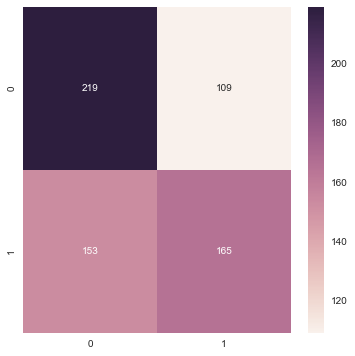

In [315]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test_inner,predictions),annot=True, fmt="d")

In [316]:
coeff_df = pd.DataFrame(logmodel.coef_.T,X_train_inner.columns)
coeff_df

,0
0,-2.146219
1,1.604748
2,0.192473


In [317]:
def get_optimal_bet(df,model,max_bet):
    return pd.Series(np.maximum((model.predict_proba(df) - 0.5)*2,0).T[1]*model.predict(df)*df.max(axis=1)*max_bet,index = df.index)

In [318]:
X_test_outer["bet"] = get_optimal_bet(X_test_outer.drop("bet_ratio",axis = 1),chosen_model,max_bet_per_match)

In [319]:
X_test_outer["right_wrong"] = y_test_outer

In [320]:
X_test_outer.head()

,0,1,2,bet_ratio,bet,right_wrong
1660,0.402910,0.479579,0.117512,1.50,0.000000,0
1661,0.220680,0.361226,0.418094,2.50,0.000000,1
1662,0.194448,0.688614,0.116938,1.44,123.040246,1
1663,0.373101,0.486088,0.140811,1.57,0.000000,0
1664,0.230713,0.573001,0.196286,2.05,32.381278,1


In [321]:
games_worth_betting = X_test_outer[X_test_outer["bet"] > 0]

In [322]:
calc_rolling_mean(games_worth_betting,"right_wrong").tail()

12866    0.602649
12867    0.603524
12869    0.604396
12870    0.605263
12871    0.603939
dtype: float64

In [323]:
games_worth_betting["profit"] = games_worth_betting["right_wrong"]*(games_worth_betting["bet"]*games_worth_betting["bet_ratio"])-(games_worth_betting["bet"])

C:\Users\asafa\Anaconda3\envs\py35_gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [324]:
basic_info = ["season","stage","home_team_name","away_team_name","score","predictions"]
bet_info   = ["right_wrong","bet_ratio","bet","profit"]

all_bets                         = new_matches.loc[games_worth_betting.index][basic_info].sort_index()
all_bets[bet_info]               = games_worth_betting[bet_info]
all_bets["profit_through_time"]  = calc_rolling_sum(all_bets,"profit")
all_bets["invest_through_time"]  = calc_rolling_sum(all_bets,"bet")

all_bets.reset_index(drop=True,inplace=True)

all_bets.head()

,season,stage,home_team_name,away_team_name,score,predictions,right_wrong,bet_ratio,bet,profit,profit_through_time,invest_through_time
0,2012/2013,15,Liverpool,Southampton,1 - 0,1,1,1.44,123.040246,54.137708,0.000000,0.000000
1,2012/2013,15,Newcastle United,Wigan Athletic,3 - 0,1,1,2.05,32.381278,34.000342,54.137708,123.040246
2,2012/2013,16,Everton,Tottenham Hotspur,2 - 1,1,1,2.00,54.118933,54.118933,88.138050,155.421524
3,2012/2013,16,Fulham,Newcastle United,2 - 1,1,1,1.95,19.847272,18.854908,142.256983,209.540457
4,2012/2013,16,Southampton,Reading,1 - 0,1,1,1.95,34.739351,33.002384,161.111891,229.387729


In [325]:
print("Mean Bet             =", all_bets["bet"].mean(),"$")
print("Max  Bet             =", all_bets["bet"].max(),"$")
print("Min  Bet             =", all_bets["bet"].min(),"$","\n")
print("Mean Profit          =", all_bets["profit"].mean(),"$")
print("Max  Profit          =", all_bets["profit"].max(),"$")
print("Min  Profit          =", all_bets["profit"].min(),"$","\n")
print("Total Money Invested =", all_bets["bet"].sum(),"$")
print("Profits              =", all_bets["profit"].sum(),"$")
print("Profit Percentage    =",(all_bets["profit"].sum()/all_bets["bet"].sum())*100,"%")

Mean Bet             = 118.35834254554372 $
Max  Bet             = 479.706866424 $
Min  Bet             = 0.138403878412 $ 

Mean Profit          = 6.399157156779188 $
Max  Profit          = 122.389803267 $
Min  Profit          = -382.668084782 $ 

Total Money Invested = 54208.120885859025 $
Profits              = 2930.813977804868 $
Profit Percentage    = 5.406595782901254 %


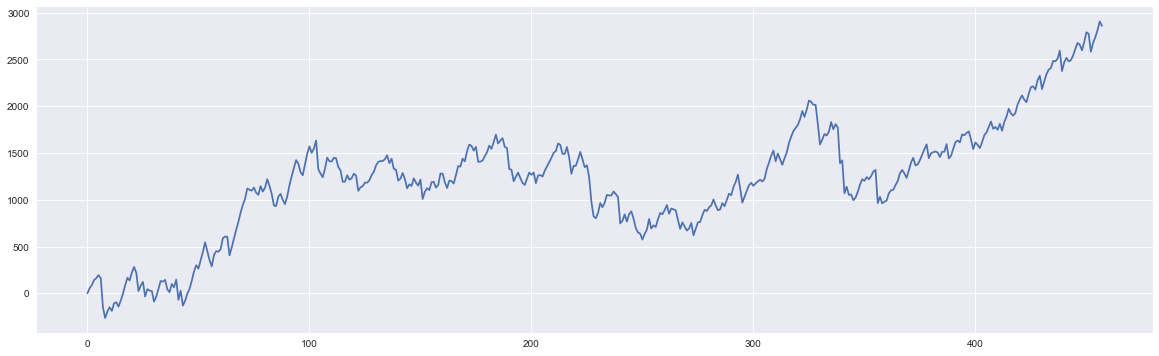

In [326]:
plt.figure(figsize=(20, 6))
plt.plot(all_bets.index,all_bets["profit_through_time"])